<a href="https://colab.research.google.com/github/AuFeld/Project2/blob/master/notebooks/Project_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
DATA_PATH = 'Project_2_Data.xlsx'

In [2]:
pip install category_encoders

     |████████████████████████████████| 102kB 2.9MB/s 


In [0]:
# import libraries
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

In [0]:
df = pd.read_excel(DATA_PATH)

In [6]:
df.head()

,Club,Season,GW_Played,Expenditure,Income,Net,Points,Points_per_GW,Expenditure_per_Point_per_GW,Manager,Owner,Champion,Relegated
0,LIV,2019,18,-2.17,47.42,45.25,49,2.722222,-0.797143,Klopp,Fenway,False,False
1,LEI,2019,19,-120.95,99.52,-21.43,39,2.052632,-58.924359,Rodgers,King_Power,False,False
2,MCI,2019,19,-191.52,78.66,-112.86,38,2.000000,-95.760000,Guardiola,City_Football,False,False
3,CHE,2019,19,-51.30,166.16,114.86,32,1.684211,-30.459375,Lampard,Abramovich,False,False
4,SHU,2019,19,-54.15,0.00,-54.15,28,1.473684,-36.744643,Wilder,Al_Saud,False,False


In [0]:
# choose your target. which column in will you predict? 
# target: 2019 Champion

In [0]:
# regression or classification?
# classification

In [0]:
# evaluation metrics: accuracy

In [0]:
columns = ['Club', 'Season', 'GW_Played', 'Expenditure', 'Income', 'Net', 
           'Points', 'Points_per_GW', 'Expenditure_per_Point_per_GW', 'Manager',
           'Owner', 'Champion', 'Relegated']

In [0]:
# split data by season

train = df[df['Season'] < 2018]
val = df[df['Season'] == 2018]
test = df[df['Season'] == 2019]

In [9]:
train.shape, val.shape, test.shape

((460, 13), (20, 13), (20, 13))

In [10]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
Champion,460,2,False,437
Relegated,460,2,False,391
Club,460,47,MAN,23
Owner,460,66,ITV_plc,23
Manager,460,136,Wenger,23


In [12]:
# null values?
df.isna().sum()

Club                            0
Season                          0
GW_Played                       0
Expenditure                     0
Income                          0
Net                             0
Points                          0
Points_per_GW                   0
Expenditure_per_Point_per_GW    0
Manager                         0
Owner                           0
Champion                        0
Relegated                       0
dtype: int64

In [0]:
# assign variables
target = 'Champion'
#features = df.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [51]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Club', 'Manager', 'Owner'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Club',
                                          'data_type': dtype('O'),
                                          'mapping': MCI      1
MAN      2
TOT      3
LIV      4
CHE      5
ARS      6
BUR      7
EVE      8
LEI      9
BOU     10
CRY     11
NEW     12
WHU     13
WAT     14
BHA     15
HUD     16
SOU     17
STK     18
SWA     19
WBA     20
HUL     21
MID     22
SUN     23
NOR     24
AVL     25
QPR     26
FUL     27
CAR     28
WIG...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto

In [52]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.95


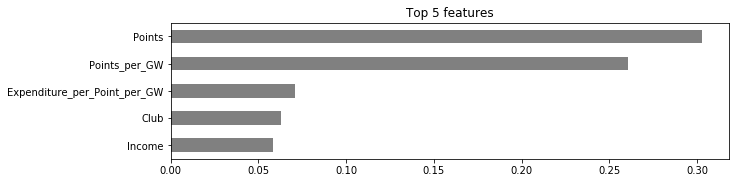

In [54]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [34]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.95


In [38]:
# fit_transfom on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 trees, depends on early stopping
    max_depth=10,        # try deeper trees because of high cardinality categoricals
    learning_rate=0.5,  # try higher learning rate
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='logloss', 
          early_stopping_rounds=50) # Stop if the score hasn't improved in 50 rounds

[0]	validation_0-logloss:0.336852	validation_1-logloss:0.36019
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.20132	validation_1-logloss:0.241181
[2]	validation_0-logloss:0.127448	validation_1-logloss:0.19249
[3]	validation_0-logloss:0.086975	validation_1-logloss:0.159807
[4]	validation_0-logloss:0.063053	validation_1-logloss:0.14815
[5]	validation_0-logloss:0.04768	validation_1-logloss:0.142889
[6]	validation_0-logloss:0.0381	validation_1-logloss:0.121503
[7]	validation_0-logloss:0.031607	validation_1-logloss:0.116172
[8]	validation_0-logloss:0.027093	validation_1-logloss:0.120578
[9]	validation_0-logloss:0.023966	validation_1-logloss:0.121561
[10]	validation_0-logloss:0.021676	validation_1-logloss:0.124964
[11]	validation_0-logloss:0.020098	validation_1-logloss:0.120005
[12]	validation_0-logloss:0.018855	validation_1-logloss:0.123174
[13]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

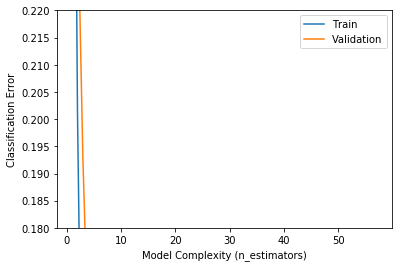

In [40]:

results = model.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

In [0]:
# Linear models have coefficients, but tree ensembles do not.
# Instaed, to see the relationship between individual feature(s) and the target, 
# we can use partial dependence plots.

In [0]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
Cross-validation MAE 8.679222408026755


In [0]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.

row = X_test.iloc[[0]]  # Dataframe with a single row (double brackets keeps it a dataframe)

In [0]:
# What was the actual value for this club?
y_test.iloc[[0]]

0    0
Name: Points, dtype: int64

In [0]:
pip install shap

     |████████████████████████████████| 266kB 4.6MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382259 sha256=c9ed6b0c69157065e17587f18aef5debc9987f5376b8c398ce525d8a05529b34
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


In [0]:
# Base value is approximately equal to the mean baseline
explainer.expected_value, y_train.mean()

(52.033779264214076, 52.03913043478261)

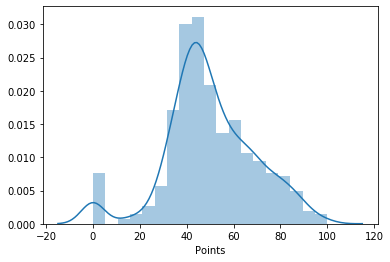

In [0]:
y = df['Points']
sns.distplot(y);

In [0]:
# log transform from _231 notes

import numpy as np
y_log = np.log1p(y)

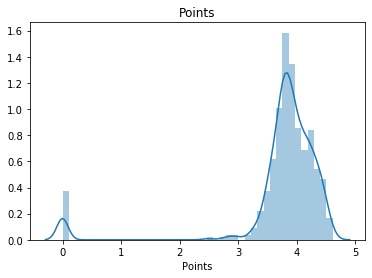

In [0]:

sns.distplot(y_log)
plt.title('Points');